In [1]:
import MySQLdb
import csv
import os
import subprocess
import re
import bz2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def write_header():
    head = ["cid","time","compile","vmlinux","GZIP-bzImage","GZIP-vmlinux","GZIP","BZIP2-bzImage","BZIP2-vmlinux","BZIP2","LZMA-bzImage","LZMA-vmlinux","LZMA","XZ-bzImage","XZ-vmlinux","XZ","LZO-bzImage","LZO-vmlinux","LZO","LZ4-bzImage","LZ4-vmlinux","LZ4"]
    with open("stats.csv", 'w') as file:
        writer = csv.DictWriter(file,head)
        writer.writeheader()

In [3]:
def kernel2csv(compressed):
    if compressed is None:
        return [str(-1)] * 18
    
    compressed = compressed.split(" , ")
    parse_array = [i.split(" : ") for i in compressed]
    final = [fin[1] for fin in parse_array]

    return final

In [4]:
## Virtual machine IP adress
HOST            = "148.60.11.195"

## MySQL user
DB_USER         = "script2"

## MySQL password
DB_PASSWD       = "ud6cw3xNRKnrOz6H"

In [5]:
def convert_time(value):
    unit = "secondes"
    value = float(value)
    if value >= 60.0 and unit == "secondes":
        value = value/60.0
        unit = "minutes"
    
    if value >= 60.0 and unit == "minutes":
        value = value/60.0
        unit = "hours"
        
    if value >= 24 and unit == "hours":
        value = value / 24.0
        unit = "days"

    tmp = str(value).split(".")
    value = tmp[0] + "." + tmp[1][:2]
        
    return value, unit

In [6]:
def convert_size(value):
    unit = "o"
    value = float(value)
    if value >= 1000.0 and unit == "o":
        value = value / 1000.0
        unit = "ko"
    
    if value >= 1000.0 and unit == "ko":
        value = value / 1000.0
        unit = "Mo"
    
    if value >= 1000.0 and unit == "Mo":
        value = value / 1000.0
        unit = "Go"
        
    tmp = str(value).split(".")
    value = tmp[0] + "." + tmp[1][:3]
    
    return value, unit

In [7]:
def succeed(entry):

    for i in range(len(entry)-1):
        if "-1" in str(entry[i]) or "-2" in str(entry[i]) or "-3" in str(entry[i]):
            return [False]

    return [True]

In [8]:
def create_csv():
    
    subprocess.run("rm stats.csv", shell=True)
    if not os.path.exists("stats.csv"):
        write_header()  
        
    entry_unformatted = compute_rows()
    entry = []
    for i in range(len(entry_unformatted)):
        compil = succeed(entry_unformatted[i])
        compr = kernel2csv(entry_unformatted[i][3])
        entry.append(list(entry_unformatted[i][0: 2]) + compil + [entry_unformatted[i][2]] + compr)
    
    with open("stats.csv", 'a') as file:
        writer = csv.writer(file)
        for line in entry:
            writer.writerow(line)
    

In [9]:
def compute_rows():
    try:
        socket = MySQLdb.connect(HOST, DB_USER, DB_PASSWD, "IrmaDB_prod")
        cursor = socket.cursor()
        
        query = "SELECT cid, compilation_time, core_size, compressed_sizes FROM Compilations WHERE cid >= 1000 ORDER BY cid DESC"
        cursor.execute(query)
        entry = cursor.fetchall()
    except:
        print("Error")
    finally:
        cursor.close()
        socket.close()
    
    return entry

In [10]:
def min_max():
    
    df = pd.read_csv('stats.csv')
    ok_or_not = True
    
    size_max = df["vmlinux"].where(df["compile"] == ok_or_not).max()
    size_min = df["vmlinux"].where((df["compile"] == ok_or_not) & (df["vmlinux"] > 0)).min()
    tmp_size_average = df["vmlinux"].where((df["compile"] == ok_or_not) & (df["vmlinux"] > 0)).mean()
    size_average = float(str(tmp_size_average).split('.')[0] + '.' + str(tmp_size_average).split('.')[1][:3])
    
    size_max, size_max_unit = convert_size(size_max)
    size_min, size_min_unit = convert_size(size_min)
    size_average, size_average_unit = convert_size(size_average)
    
    time_max = df["time"].where(df["compile"] == ok_or_not).max()
    time_min = df["time"].where((df["compile"] == ok_or_not) & (df["time"] > 0)).min()
    tmp_time_average = df["time"].where((df["compile"] == ok_or_not) & (df["time"] > 0)).mean()
    
    time_average = float(str(tmp_time_average).split('.')[0] + '.' + str(tmp_time_average).split('.')[1][:3])
    
    time_max, time_max_unit = convert_time(time_max)
    time_min, time_min_unit = convert_time(time_min)
    time_average, time_average_unit = convert_time(time_average)
    
    print("Number of values:", len(df))
    
    print("Time Max:", time_max, time_max_unit, end="")
    print(", Min:", time_min, time_min_unit, end="")
    print("\taverage:", time_average, time_average_unit)
    
    print("Size Max:", size_max, size_max_unit, end="")
    print(", Min:", size_min, size_min_unit, end="")
    print("\t\taverage:", size_average, size_average_unit)
    
    box = df["vmlinux"].where((df["compile"] == ok_or_not) & (df["vmlinux"] > 0)).plot.box(sym='', showmeans=True)
    plt.ylabel("vmlinux size")
    plt.show()
    
    box = df["time"].where((df["compile"] == ok_or_not) & (df["time"] > 0)).plot.box(sym='', showmeans=True)
    plt.ylabel("Time")
    plt.show()

In [11]:
create_csv()

Number of values: 69289
Time Max: 1.31 hours, Min: 1.85 secondes	average: 6.58 minutes
Size Max: 1.823 Go, Min: 1.168 Mo		average: 73.747 Mo


/home/alemasle/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


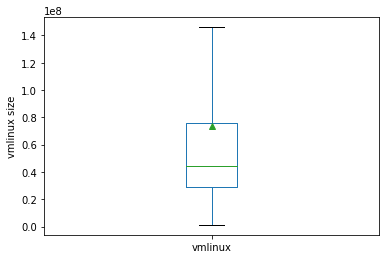

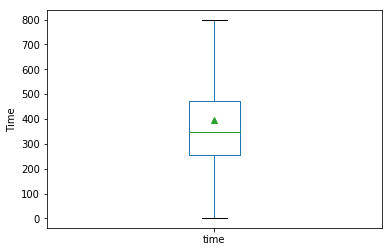

In [12]:
min_max()